## 사전 훈련된 Word2Vec을 이용한 영어-한국어 번역 모형

In [1]:
import os
os.chdir('C:/Users/HK/Desktop/GitHub/Deep-Learning/NLP')

import gensim
import nltk
import konlpy
import keras
import numpy as np
import pandas as pd

Using TensorFlow backend.


> ### 사전 훈련된 워드벡터 준비

- 언어별 Word2Vec 불러오기

In [2]:
from gensim.models import Word2Vec
korvec = Word2Vec.load('datasets/ko.bin')

C:\Anaconda3\lib\site-packages\gensim\models\base_any2vec.py:743: UserWarning: C extension not loaded, training will be slow. Install a C compiler and reinstall gensim for fast training.
  "C extension not loaded, training will be slow. "


In [3]:
from gensim.models import KeyedVectors
engvec = KeyedVectors.load_word2vec_format('datasets/GoogleNews-vectors-negative300.bin', binary = True)

> ### 데이터 준비

- 출처: Manythings.org http://www.manythings.org/anki/kor-eng.zip

In [4]:
lines = pd.read_table('datasets/kor.txt', names = ['source', 'target'])
print(len(lines), 'observations')
lines.sample(10)

909 observations


,source,target
373,Let's go somewhere warm.,따뜻한 곳에 가자.
279,That's my dictionary.,그건 내 사전이야.
355,He invited me to dinner.,그는 나를 저녁 식사에 초대했다.
843,"How many boys do you have? ""I only have one.""","형제가 몇 명이나 있어? ""한 명 있어."""
847,Tom currently lives alone in a small apartment.,탐은 현재 작은 아파트에서 혼자 살고 있다.
640,He went on walking for two hours.,그는 두 시간 동안 더 걸었다.
189,Excuse me a minute.,잠깐 실례합니다.
679,Snakes are cold-blooded creatures.,뱀들은 냉혈동물이다.
648,Let's hear the rest of the story.,이야기를 마저 들어보자.
42,You're mine.,넌 내 거야.


In [5]:
lines.target = lines.target.apply(lambda x : '<sos> ' + x + ' <eos>')
lines.sample(10)

,source,target
553,You need to accept your role.,<sos> 넌 너의 역할을 받아들일 필요가 있어. <eos>
666,I want to learn Chinese next year.,<sos> 나는 내년에 중국어를 배우고 싶다. <eos>
681,Tom and Mary are in the same boat.,<sos> 톰과 마리는 같은 배를 탔다. <eos>
499,I already know you did that.,<sos> 네가 그것을 했다는 것을 이미 알고 있다. <eos>
701,"Tom began to sing ""Happy Birthday.""","<sos> Tom이 ""Happy Birthday"" 노래를 부르기 시작했다. <eos>"
552,Why don't you leave me alone?,<sos> 날 좀 가만히 내버려 둬. <eos>
27,Hold still.,<sos> 가만히 있으세요. <eos>
593,It rained throughout the night.,<sos> 밤새 비가 내렸다. <eos>
848,You need good equipment to climb that mountain.,<sos> 저 산에 오르려면 좋은 장비가 있어야 돼. <eos>
663,I hope you tore up my last letter.,<sos> 내 마지막 편지는 찢어 버렸길 바란다. <eos>


In [6]:
from keras.preprocessing.text import Tokenizer

In [7]:
source_t = Tokenizer()
source_t.fit_on_texts(lines.source)
source_vocab_size = len(source_t.word_index) + 1

target_t = Tokenizer()
target_t.fit_on_texts(lines.target)
target_vocab_size = len(target_t.word_index) + 1

In [8]:
print(source_vocab_size)
print(target_vocab_size)

1170
2049


In [9]:
encoder_input_data = source_t.texts_to_sequences(lines.source)
source_max_length = max(len(l) for l in encoder_input_data)

decoder_input_data = target_t.texts_to_sequences(lines.target)
decoder_target_data = [l[1:] for l in decoder_input_data]
target_max_length = max(len(l) for l in decoder_input_data)

In [10]:
print(source_max_length)
print(target_max_length)

19
17


In [11]:
# sample
print(encoder_input_data[0])
print(decoder_input_data[0])
print(decoder_target_data[0])

[92]
[1, 264, 2]
[264, 2]


In [12]:
from keras.preprocessing.sequence import pad_sequences

In [13]:
encoder_input_data = pad_sequences(
    encoder_input_data, maxlen = source_max_length, padding = 'post')
decoder_input_data = pad_sequences(
    decoder_input_data, maxlen = target_max_length, padding = 'post')
decoder_target_data = pad_sequences(
    decoder_target_data, maxlen = target_max_length, padding = 'post')

In [14]:
from keras.utils import to_categorical

In [15]:
decoder_target_data = to_categorical(decoder_target_data)

In [16]:
print(encoder_input_data.shape)
print(decoder_input_data.shape)
print(decoder_target_data.shape)

(909, 19)
(909, 17)
(909, 17, 2049)


In [17]:
encoder_embedding_dim = engvec.vector_size
encoder_pretrained_embedding = np.random.normal(
    scale = 0.5, size = (source_vocab_size, encoder_embedding_dim))

n1 = 0
for word, i in source_t.word_index.items():
    if engvec.vocab.get(word) is not None:
        encoder_pretrained_embedding[i] = engvec.get_vector(word)
        n1 += 1

In [18]:
print(encoder_pretrained_embedding.shape)
print(n1)

(1170, 300)
1148


In [19]:
decoder_embedding_dim = korvec.vector_size
decoder_pretrained_embedding = np.random.normal(
    scale = 0.5, size = (target_vocab_size, decoder_embedding_dim))

n2 = 0
for word, i in target_t.word_index.items():
    if korvec.wv.vocab.get(word) is not None:
        decoder_pretrained_embedding[i] = korvec.wv.get_vector(word)
        n2 += 1

In [20]:
print(decoder_pretrained_embedding.shape)
print(n2)
# 조사 때문에 너무 적다..

(2049, 200)
344


> ### 시퀀스-투-시퀀스 모델

In [21]:
from keras.layers import Input, GRU, LSTM, Embedding, Dense
from keras.models import Model, load_model, save_model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import optimizers
from keras import initializers
import keras.backend as K

K.clear_session()

In [22]:
encoder_embedding_layer = Embedding(input_dim = source_vocab_size, 
                                    output_dim = encoder_embedding_dim,
                                    input_length = source_max_length,
                                    weights = [encoder_pretrained_embedding])
decoder_embedding_layer = Embedding(input_dim = target_vocab_size, 
                                    output_dim = decoder_embedding_dim,
                                    input_length = target_max_length,
                                    weights = [decoder_pretrained_embedding])

In [23]:
units = 64

encoder_inputs = Input((None,))
encoder_embedding = encoder_embedding_layer(encoder_inputs)
encoder_rnn = LSTM(units = units, return_state = True)
encoder_outputs, state_h, state_c = encoder_rnn(encoder_embedding)
encoder_states = [state_h, state_c]

decoder_inputs = Input((None,))
decoder_embedding = decoder_embedding_layer(decoder_inputs)
decoder_rnn = LSTM(units = units, return_sequences = True, return_state = True)
decoder_outputs, _, _ = decoder_rnn(decoder_embedding, initial_state = encoder_states)

decoder_softmax_layer = Dense(target_vocab_size, activation = 'softmax')
decoder_outputs = decoder_softmax_layer(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [24]:
model.compile(loss = "categorical_crossentropy",
              optimizer = optimizers.rmsprop(),
              metrics = ['acc'])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 19, 300)      351000      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 17, 200)      409800      input_2[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LS

In [25]:
model.load_weights('models/pretrained-word2vec-eng-to-kor-trainable.hdf5')

In [63]:
epochs = 300
batch_size = 128

modelpath = 'models/pretrained-word2vec-eng-to-kor-trainable.hdf5'
check = ModelCheckpoint(modelpath, monitor = 'val_acc', save_best_only = True, save_weights_only = True)
early = EarlyStopping(monitor = 'val_acc', patience = 50)

history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data, 
                    validation_split = 0.2, callbacks = [check, early],
                    epochs = epochs, batch_size = batch_size, verbose = 2)

Train on 727 samples, validate on 182 samples
Epoch 1/300
 - 11s - loss: 6.9495 - acc: 0.5983 - val_loss: 6.3874 - val_acc: 0.5692
Epoch 2/300
 - 6s - loss: 5.3987 - acc: 0.7315 - val_loss: 5.3663 - val_acc: 0.5692
Epoch 3/300
 - 6s - loss: 4.3472 - acc: 0.7315 - val_loss: 4.7054 - val_acc: 0.5692
Epoch 4/300
 - 6s - loss: 3.6030 - acc: 0.7315 - val_loss: 4.2037 - val_acc: 0.5692
Epoch 5/300
 - 7s - loss: 3.0428 - acc: 0.7315 - val_loss: 3.8512 - val_acc: 0.5692
Epoch 6/300
 - 7s - loss: 2.6503 - acc: 0.7315 - val_loss: 3.6286 - val_acc: 0.5692
Epoch 7/300
 - 7s - loss: 2.3843 - acc: 0.7315 - val_loss: 3.4686 - val_acc: 0.5692
Epoch 8/300
 - 7s - loss: 2.1945 - acc: 0.7315 - val_loss: 3.3611 - val_acc: 0.5692
Epoch 9/300
 - 6s - loss: 2.0596 - acc: 0.7315 - val_loss: 3.2849 - val_acc: 0.5692
Epoch 10/300
 - 5s - loss: 1.9604 - acc: 0.7315 - val_loss: 3.2281 - val_acc: 0.5692
Epoch 11/300
 - 5s - loss: 1.8852 - acc: 0.7315 - val_loss: 3.1885 - val_acc: 0.5692
Epoch 12/300
 - 5s - loss: 

Epoch 97/300
 - 4s - loss: 0.7398 - acc: 0.8692 - val_loss: 4.1411 - val_acc: 0.6422
Epoch 98/300
 - 4s - loss: 0.7323 - acc: 0.8713 - val_loss: 4.1569 - val_acc: 0.6429
Epoch 99/300
 - 4s - loss: 0.7216 - acc: 0.8743 - val_loss: 4.1485 - val_acc: 0.6425
Epoch 100/300
 - 4s - loss: 0.7145 - acc: 0.8776 - val_loss: 4.1655 - val_acc: 0.6422
Epoch 101/300
 - 4s - loss: 0.7049 - acc: 0.8809 - val_loss: 4.1783 - val_acc: 0.6422
Epoch 102/300
 - 4s - loss: 0.6957 - acc: 0.8826 - val_loss: 4.1668 - val_acc: 0.6429
Epoch 103/300
 - 4s - loss: 0.6892 - acc: 0.8858 - val_loss: 4.1762 - val_acc: 0.6422
Epoch 104/300
 - 3s - loss: 0.6782 - acc: 0.8886 - val_loss: 4.1680 - val_acc: 0.6419
Epoch 105/300
 - 3s - loss: 0.6714 - acc: 0.8900 - val_loss: 4.1941 - val_acc: 0.6419
Epoch 106/300
 - 3s - loss: 0.6627 - acc: 0.8924 - val_loss: 4.1686 - val_acc: 0.6419
Epoch 107/300
 - 3s - loss: 0.6534 - acc: 0.8945 - val_loss: 4.1794 - val_acc: 0.6422
Epoch 108/300
 - 3s - loss: 0.6467 - acc: 0.8963 - val_lo

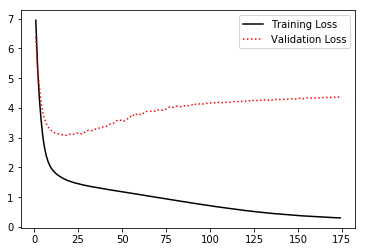

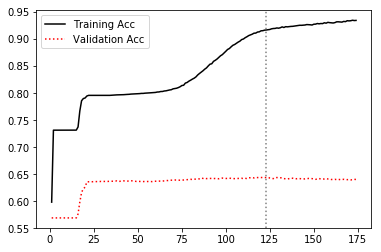

epoch 123: Training Acc = 91.75%, Validation Acc = 64.45%


In [64]:
import matplotlib.pyplot as plt

def history_plot(history):
    epoch = range(1, len(history.history['loss']) + 1)
    m = np.argmax(history.history['val_acc'])
    plt.plot(epoch, history.history['loss'], '-k', label = 'Training Loss')
    plt.plot(epoch, history.history['val_loss'], ':r', label = 'Validation Loss')
    plt.legend()
    plt.show()

    plt.plot(epoch, history.history['acc'], '-k', label = 'Training Acc')
    plt.plot(epoch, history.history['val_acc'], ':r', label = 'Validation Acc')
    plt.axvline(m, linestyle = ':', color = 'gray')
    plt.legend()
    plt.show()
    
    print('epoch {}: Training Acc = {}%, Validation Acc = {}%'.
          format(m, np.round(history.history['acc'][m], 4)*100, np.round(history.history['val_acc'][m], 4)*100))
    
history_plot(history)

In [26]:
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape = (units,))
decoder_state_input_c = Input(shape = (units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_embedding_p = decoder_embedding_layer(decoder_inputs)
decoder_outputs_p, state_h_p, state_c_p = decoder_rnn(
    decoder_embedding_p, initial_state = decoder_states_inputs)

decoder_states_p = [state_h_p, state_c_p]
decoder_outputs_p = decoder_softmax_layer(decoder_outputs_p)

decoder_model = Model([decoder_inputs] + decoder_states_inputs, 
                      [decoder_outputs_p] + decoder_states_p)

In [27]:
index_to_source = dict((i, char) for char, i in source_t.word_index.items())
index_to_target = dict((i, char) for char, i in target_t.word_index.items())

In [28]:
def decode_sentence(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = target_t.word_index['sos']
    print(np.array(states_value).shape)
    stop_condition = False
    decoded_sentence = ''
    
    # stop_condition이 True가 될 때까지 루프 반복
    while not stop_condition: 
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = index_to_target[sampled_token_index]
        decoded_sentence += ' ' + sampled_char
        
        # 문장 끝에 도달하거나 최대 길이를 넘으면 중단
        if (sampled_char == 'eos' or
           len(decoded_sentence) > target_max_length):
            stop_condition = True
        
        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index
        
        # 상태를 업데이트
        states_value = [h, c]
        
    return decoded_sentence

In [ ]:
for i in np.random.randint(0, len(lines) - 1, 3):
    input_seq = encoder_input_data[i: i + 1]
    decoded_sentence = decode_sentence(input_seq)
    
    print(lines.source[i])
    print(lines.target[i][1: target_max_len + 1])
    print(decoded_sentence)